# Parameter Uncertanty in Capital Requirement

Final project for the 2018-2019 ay course in FinEng at Politecnico di Milano

In [1]:
import numpy as np
import scipy
import scipy.stats
import pandas as pd
import utils
import src
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = [10, 5]
import importlib
importlib.reload(src)
importlib.reload(utils)

<module 'utils' from '/Users/Martino/Documents/GitHub/FinEngFinalProj/python/utils.py'>

In [3]:
fileName = "../data/dati_Altman.csv"
data = pd.read_csv(fileName, names=['year','DR_SG','DR_AG','RR'], index_col = 'year', header = 0)
data.head()

,DR_SG,DR_AG,RR
year,,,
1982,0.0319,0.0319,0.386
1983,0.0109,0.0109,0.557
1984,0.0084,0.0084,0.486
1985,0.0171,0.0171,0.459
1986,0.0350,0.0350,0.345


In [4]:
# parameter definition

N_obligors = 60
N_simulations = 5*10**5

confidenceLevel = 0.99

rho_mean = 0.0924
rho_std = 0.0388

systematicRisk = np.random.normal(0,1,size=N_simulations)
idiosyncraticRisk = np.random.normal(0,1,size=[N_simulations,N_obligors])

# Data Visulalization

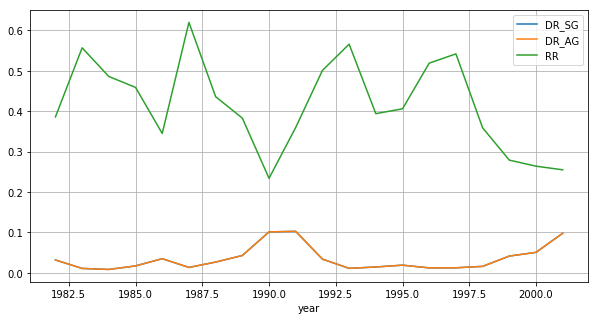

In [5]:
data.plot(grid=True)

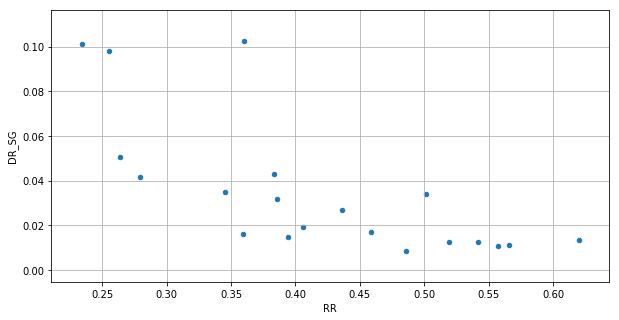

In [6]:
data.plot(kind='scatter', x='RR', y='DR_SG', grid = True)

### Normality assumptions

In [7]:
d = scipy.stats.norm.ppf(data.DR_SG)
    # Shapiro-Wilk test
[w_d,pValue_d] = scipy.stats.shapiro(d)
[w_RR,pValue_RR] = scipy.stats.shapiro(data.RR)
    # Results
print("pValue_d = {0:.3f}".format(pValue_d))
print("pValue_RR = {0:.3f}".format(pValue_RR))

pValue_d = 0.041
pValue_RR = 0.674


# Frequentis Approach

### Parameter estimation

In [8]:
# default rate sample mean and std
DR_mean = data.DR_SG.mean()
DR_std = data.DR_SG.std()

In [9]:
# unbiased mean of defualt barrier

d_std = np.std(scipy.stats.norm.ppf(data.DR_SG),ddof=1)

def f(d_hat):
    f0 = lambda x: scipy.stats.norm.pdf(x)*scipy.stats.norm.cdf(d_hat+d_std*x)
    return scipy.integrate.quad(f0,-30,30)[0]-DR_mean

d_hat = scipy.optimize.newton(f, 0)

In [10]:
# recovery rate sample mean and std

RR_mean = data.RR.mean()
RR_std = data.RR.std()

## Frequentis Results

#### Sample correlation

In [11]:
# Large Homogeneous Portfolio
RC_LHP = src.CapitalRequirementNominalLHP(RR_mean,DR_mean,rho_mean,confidenceLevel)
# Homogeneous Portfolio
RC_HP = src.CapitalRequirementNominalHP(RR_mean,DR_mean,rho_mean,confidenceLevel,N_obligors)

In [12]:
print("RC LHP 99% = {0:.4f}".format(RC_LHP))
print("RC HP 99% = {0:.4f}".format(RC_HP))

RC LHP 99% = 0.0513
RC HP 99% = 0.0670


#### Basel correlation

In [13]:
rho_Basel_mean = utils.correlationFromBasel2(DR_mean)

# Large Homogeneous Portfolio
RC_LHP_Basel = src.CapitalRequirementNominalLHP(RR_mean,DR_mean,rho_Basel_mean,confidenceLevel)
# Homogeneous PortFolio
RC_HP_Basel = src.CapitalRequirementNominalHP(RR_mean,DR_mean,rho_Basel_mean,confidenceLevel,N_obligors)

In [14]:
print("RC LHP 99% basel = {0:.4f}".format(RC_LHP_Basel))
print("RC HP 99% basel = {0:.4f}".format(RC_HP_Basel))

RC LHP 99% basel = 0.0702
RC HP 99% basel = 0.0864


## Alternative model

In [15]:
# B.2 - B.3 Simulations required
d_sim_f  = d_hat + np.random.normal(0,1,size=N_simulations)*d_std
DR_sim_f = scipy.stats.norm.cdf(d_sim_f)

RR_sim_f = RR_mean + np.random.normal(0,1,size=N_simulations)*RR_std

[alpha,beta] = utils.betaParameter(rho_mean,rho_std)
rho_sim_f = np.random.beta(alpha,beta,size=N_simulations)

rho_sim_B_f = utils.correlationFromBasel2(DR_sim_f)

In [16]:
RCf_LHP_d = src.CapitalRequirementAlternativeLHP(RR_mean,DR_sim_f,rho_mean,confidenceLevel,systematicRisk) 
RCf_LHP_RR = src.CapitalRequirementAlternativeLHP(RR_sim_f,DR_mean,rho_mean,confidenceLevel,systematicRisk) 
RCf_LHP_rho = src.CapitalRequirementAlternativeLHP(RR_mean,DR_mean,rho_sim_f,confidenceLevel,systematicRisk) 
RCf_LHP_d_rho = src.CapitalRequirementAlternativeLHP(RR_mean,DR_sim_f,rho_sim_f,confidenceLevel,systematicRisk)
RCf_LHP_all = src.CapitalRequirementAlternativeLHP(RR_sim_f,DR_sim_f,rho_sim_f,confidenceLevel,systematicRisk)

In [17]:
print("Addon frequentist DR = {0:.4f}".format(RCf_LHP_d/RC_LHP-1))
print("Addon frequentist RR = {0:.4f}".format(RCf_LHP_RR/RC_LHP-1))
print("Addon frequentist rho = {0:.4f}".format(RCf_LHP_rho/RC_LHP-1))
print("Addon frequentist rho and DR = {0:.4f}".format(RCf_LHP_d_rho/RC_LHP-1))
print("Addon frequentist all = {0:.4f}".format(RCf_LHP_all/RC_LHP-1))

Addon frequentist DR = 0.7513
Addon frequentist RR = 0.0737
Addon frequentist rho = 0.0415
Addon frequentist rho and DR = 0.7603
Addon frequentist all = 0.8351


# Bayesian Inference

In [18]:
# poterior for d (closed formula)

n       = len(data)               # number of observations
mu_d    = sum(scipy.stats.norm.ppf(data.DR_SG))/(n+d_std**2)               # posterion mean
sigma_d = d_std/np.sqrt(n+d_std**2)           # posterior standard deviation

d_sim_bayes  = mu_d + np.random.normal(0,1,N_simulations)*sigma_d  # simulated d from posterior
DR_sim_bayes = scipy.stats.norm.cdf(d_sim_bayes)               # simulated default rate

In [19]:
# posterior d (mcmc)

logPrior = lambda x: np.log(scipy.stats.norm.pdf(x,0,1))
logLiklihood = lambda x: np.sum(np.log(scipy.stats.norm.pdf(scipy.stats.norm.ppf(data.DR_SG),x,d_std)))

# takes approx 4min 
#d_sim_bayes_mcmc = utils.mcmc(d_hat, logPrior, logLiklihood ,0.2, N_simulations)

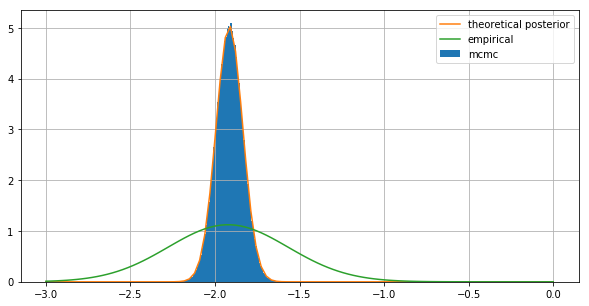

In [20]:
# plot posterior vs empirical distribution

ax = plt.hist(d_sim_bayes,100,density=True)
#ax = plt.hist(d_sim_bayes_mcmc,100,density=True)
[x_min,x_max] = [-3,0]
xx = np.linspace(x_min,x_max,100)
plt.plot(xx,scipy.stats.norm.pdf(xx,mu_d,sigma_d))
plt.plot(xx,scipy.stats.norm.pdf(xx,d_hat,d_std))
plt.grid(True)
plt.legend(['theoretical posterior','empirical','mcmc'])

In [21]:
# rho posterior

rho_vect  = np.linspace(0.005,0.995,1980)       # equispaced vector
[aa,bb]   = utils.betaParameter(rho_vect,rho_std)  # A and B beta parameters

s = lambda x: rho_std
b = lambda r: (1-r)*(r*(1-r)-s(r)**2)/(s(r)**2)
a = lambda r: r/(1-r)*(1-r)*(r*(1-r)-s(r)**2)/(s(r)**2)

logPrior = lambda x: 0
logLiklihood = lambda x: np.log(scipy.stats.beta.pdf(rho_mean,a(x),b(x)))

# takes approx 1min 
#rho_sim_bayes = utils.mcmc(rho_mean, logPrior, logLiklihood ,0.2, N_simulations)

h = utils.posteriorDistributionRho(rho_mean,rho_vect,aa,bb)
rho_sim_bayes = utils.samplingFromPosterior(N_simulations,rho_vect,h)

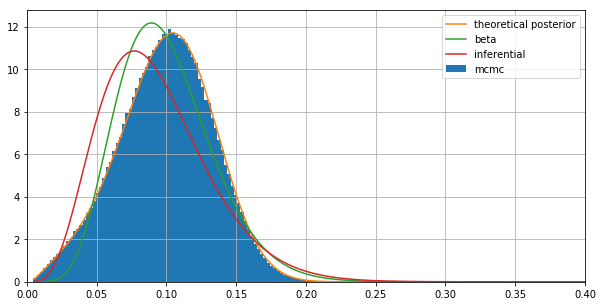

In [22]:
posterior_mean = np.trapz(h*rho_vect,rho_vect)
posterior_var = np.trapz(h*rho_vect**2,rho_vect)-posterior_mean**2

[a,b] = utils.betaParameter(posterior_mean,np.sqrt(posterior_var))

ax = plt.hist(rho_sim_bayes,100,density=True)
plt.plot(rho_vect,h)
plt.plot(rho_vect,scipy.stats.beta.pdf(rho_vect,a,b))
plt.plot(rho_vect,scipy.stats.beta.pdf(rho_vect,utils.betaParameter(rho_mean,rho_std)[0],utils.betaParameter(rho_mean,rho_std)[1]))
plt.grid(True)
plt.xlim([0,0.4])
plt.legend(['theoretical posterior','beta','inferential','mcmc'])

## Bayesian Empirial Variance Results

In [23]:
RC_bayes_LHP_d   = src.CapitalRequirementAlternativeLHP(RR_mean,scipy.stats.norm.cdf(d_sim_bayes),
                                                     rho_mean,confidenceLevel,systematicRisk)       # default rate
RC_bayes_LHP_rho = src.CapitalRequirementAlternativeLHP(RR_mean,DR_mean,
                                               rho_sim_bayes,confidenceLevel,systematicRisk)               # correlation
RC_bayes_LHP_all = src.CapitalRequirementAlternativeLHP(RR_mean,DR_sim_bayes,
                                               rho_sim_bayes,confidenceLevel,systematicRisk)               # default rate, correlation

In [24]:
print("Addon bayesian DR = {0:.4f}".format(RC_bayes_LHP_d/RC_LHP-1))
print("Addon bayesian rho = {0:.4f}".format(RC_bayes_LHP_rho/RC_LHP-1))
print("Addon bayesian DR and rho = {0:.4f}".format(RC_bayes_LHP_all/RC_LHP-1))

Addon bayesian DR = -0.1096
Addon bayesian rho = 0.0894
Addon bayesian DR and rho = -0.0371


## Cramer Rao

In [25]:
d_vect    = np.linspace(-4,0,500)

# takes 10min
d_CRstd   = utils.CramerRao_d(rho_mean,d_vect,N_obligors,len(data))
h_d_CR    = utils.posteriorDistributionD(d_hat,d_vect,d_CRstd);

d_sim_bCR  = utils.samplingFromPosterior(N_simulations,d_vect,h_d_CR) # simulated threshold
DR_sim_bCR = scipy.stats.norm.cdf(d_sim_bCR)                  # simulated default rate


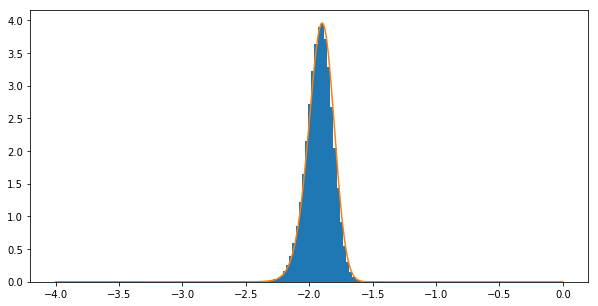

In [26]:
ax = plt.hist(d_sim_bCR,100,density=True)
plt.plot(d_vect,h_d_CR)

In [27]:
rho_vect  = np.linspace(0.005,0.995,1980)
rho_CRstd = utils.CramerRao_rho(10891,rho_vect,30)
[aa,bb]   = utils.betaParameter(rho_vect,rho_CRstd) # A and B beta parameters
h_rho_CR  = utils.posteriorDistributionRho(rho_mean,rho_vect,aa,bb) # posterior

rho_sim_bCR = utils.samplingFromPosterior(N_simulations,rho_vect,h_rho_CR)

In [28]:
RCb_HP_d_CR = src.CapitalRequirementAlternativeHP(RR_mean,DR_sim_bCR,rho_mean,confidenceLevel,systematicRisk,idiosyncraticRisk)
RCb_HP_rho_CR = src.CapitalRequirementAlternativeHP(RR_mean,DR_mean,rho_sim_bCR,confidenceLevel,systematicRisk,idiosyncraticRisk)

In [29]:
print("Addon bayesian Cramer Rao DR = {0:.4f}".format(RCb_HP_d_CR/RC_HP-1))
print("Addon bayesian Cramer Rao rho = {0:.4f}".format(RCb_HP_rho_CR/RC_HP-1))

Addon bayesian Cramer Rao DR = -0.0846
Addon bayesian Cramer Rao rho = -0.0003
